In [177]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

In [215]:
class NeuralNet:
    
    def __init__(self, layer_dims):
        print("NeuralNet class started")
        self.X_train_org, self.Y_train_org, self.X_test_org,self.Y_test_org, self.classes = self.dataset_load()
        self.m_train = self.X_train_org.shape[0]
        self.m_test = self.X_test_org.shape[0]
        
        print("size of the dataset:",+self.m_train,"test set:",+self.m_test)
        self.X_flatten_train = self.X_train_org.reshape(self.m_train, -1).T
        print("sanity check after flatten", str(self.X_flatten_train[0:5,0]))
        self.X_train = self.X_flatten_train/255
        self.X_flatten_test = (self.X_test_org.reshape(self.m_test, -1).T)
        self.X_test = self.X_flatten_test/255
        print("size of X_train after flatten and normalization",self.X_train.shape,"size of Y",self.Y_train_org.shape)
        self.layer_dims = layer_dims
        self.layers = len(layer_dims)-1
        print("Layers in the network: ", self.layers)
        
    def wt_init(self):
        print("initializing wieghts")
        np.random.seed(3)
        self.w = []
        self.b = []
        for i in range(1,self.layers+1):
            print("i = ", i)
            w = np.random.randn(self.layer_dims[i],self.layer_dims[i-1])*0.01
            b = np.zeros((self.layer_dims[i],1))
            self.w.append(w)
            self.b.append(b)
        
        for i in range(0,self.layers):
            print(i)
            print("size of w:",self.w[i].shape)
            #print(self.w[i])
             
    def dataset_load(self):
        print("loading the dataset")
        train_dataset = h5py.File('../../DL/Course_1_NeuralNetwork_DeepLearning/Week 2/Logistic Regression as a Neural Network/datasets/train_catvnoncat.h5', "r")
        train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
        train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

        test_dataset = h5py.File('../../DL/Course_1_NeuralNetwork_DeepLearning/Week 2/Logistic Regression as a Neural Network/datasets/test_catvnoncat.h5', "r")
        test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
        test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

        classes = np.array(test_dataset["list_classes"][:]) # the list of classes

        train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
        test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

        return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
        
    def wt_train_deep(self, Type):
        if Type == "train":
            A = self.X_train
        else:
            A = self.X_test
            
        caches = []
        for i in range(0,self.layers-1):
            A_prev = A
            A, activation_cache = self.wt_train(A_prev,self.w[i],self.b[i], activation = "relu")
            caches.append(activation_cache)
            
        AL, activation_cache = self.wt_train(A,self.w[self.layers-1],self.b[self.layers-1], activation = "sigmoid")
        caches.append(activation_cache)
        
        return AL, caches
    
    def wt_train(self,a_prev,w,b, activation):
        #print("training the model")
        z = np.dot(w,a_prev)+ b
        
        if activation == "relu":
            y_hat = relu(z)
        else:
            y_hat = sigmoid(z)
            
        cache = (a_prev,w,b,z)    
            
        return y_hat, cache
    
    def compute_cost(self, AL):
        
        #cost = (-1/self.m_train)*np.sum(np.dot(self.Y_train_org,np.log(AL.T))+np.dot((1-self.Y_train_org),np.log(1-AL.T)))
        cost = (-1/self.m_train)*(np.dot(self.Y_train_org,np.log(AL.T))+np.dot((1-self.Y_train_org),np.log(1-AL.T)))
        
        cost = np.squeeze(cost)
        return cost
    
    def backward_deep(self, AL, caches):
        grades = {}
        m = AL.shape[1]
        #y = Y.reshape(AL.shape)
        dAL = -(np.divide(self.Y_train_org,AL) - np.divide(1-self.Y_train_org,1-AL))
        
        current_caches = self.backward_activation(dAL, caches[self.layers-1], activation = "sigmoid")
        grades["dA" + str(self.layers-1)],grades["dW" + str(self.layers)],grades["db" + str(self.layers)] = current_caches[0],current_caches[1],current_caches[2]
        
        # loop from 2 to 0
        for l in reversed(range(self.layers-1)):
            current_caches = self.backward_activation(grades["dA" + str(l+1)], caches[l], activation = "relu")
            grades["dA" + str(l)],grades["dW" + str(l+1)],grades["db" + str(l+1)] = current_caches[0],current_caches[1],current_caches[2]
        
        return grades
    
    def backward_activation(self, dA, caches, activation):
        
        if activation == "relu":
            dZ = relu_backward(dA, caches)
            dA_prev, dW, db = self.backward_linear(dZ, caches)
        else:
            dZ = sigmoid_backward(dA, caches)
            dA_prev, dW, db = self.backward_linear(dZ, caches)
        
        return dA_prev, dW, db
    
    def backward_linear(self, dZ, caches):
        A_prev, w, b, z = caches
        m = A_prev.shape[1]
        
        dW = (1/m)*np.dot(dZ,A_prev.T)
        db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
        dA_prev = np.dot(w.T,dZ)
        
        return dA_prev, dW, db
    
    def update_params(self, grades, learning_rate):
        
        for i in range(self.layers):
            #print("updating param: i ", i)
            self.w[i] = self.w[i] - learning_rate*grades["dW" + str(i+1)]
            self.b[i] = self.b[i] - learning_rate*grades["db" + str(i+1)]
            
    def model(self,learning_rate, iteration):
        self.wt_init()
        costs = []
        for i in range(iteration):
            AL, caches = self.wt_train_deep("train")
            #print(AL)
            cost = self.compute_cost(AL)
            grades = self.backward_deep(AL,caches)
            self.update_params(grades, learning_rate)
            
            if i%100 == 0:
                print("cost = ", cost)
                costs.append(cost)
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()    
        
    def predict(self,Type):
        AL, cachs = self.wt_train_deep(Type)
        y_prediction = np.zeros((1, AL.shape[1]))
        
        for i in range(AL.shape[1]):
            if AL[0,i] > 0.5:
                y_prediction[0,i] = 1
            else:
                y_prediction[0,i] = 0
            
        return y_prediction    

In [216]:
def relu(z):
    A = np.maximum(0,z)
    assert(A.shape == z.shape)
    return A

def sigmoid(z):
    A = 1/(1+np.exp(-z))
    return A

def relu_backward(dA, caches):
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    a_prev,w,b,z = caches    
    #print(dA.shape, dZ.shape, z.shape, a_prev.shape, w.shape)
    # When z <= 0, you should set dz to 0 as well.
    dZ[z <= 0] = 0
    return dZ

def sigmoid_backward(dA, caches):
    a_prev,w,b,z = caches
    
    s = sigmoid(z)
    dZ = dA * s * (1-s)
    #print(dA.shape, dZ.shape, z.shape, a_prev.shape, w.shape)
    return dZ

NeuralNet class started
loading the dataset
size of the dataset: 209 test set: 50
sanity check after flatten [17 31 56 22 33]
size of X_train after flatten and normalization (12288, 209) size of Y (1, 209)
Layers in the network:  4
initializing wieghts
i =  1
i =  2
i =  3
i =  4
0
size of w: (20, 12288)
1
size of w: (7, 20)
2
size of w: (5, 7)
3
size of w: (1, 5)
cost =  0.6931477726957999
cost =  0.6453290555117338
cost =  0.64401665159208
cost =  0.6439751350521994
cost =  0.6439737810405846
cost =  0.6439737363803634
cost =  0.6439737346479629
cost =  0.6439737343388635
cost =  0.6439737340836315
cost =  0.6439737338329581
cost =  0.6439737335874941
cost =  0.6439737333350122
cost =  0.6439737330887974
cost =  0.6439737328385673
cost =  0.6439737325955438
cost =  0.6439737323479239
cost =  0.6439737320990867
cost =  0.6439737318386501
cost =  0.64397373159463
cost =  0.6439737313358964


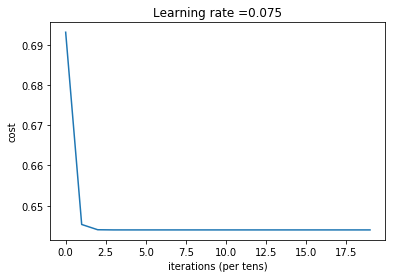

Train Accuracy:  65.5502392344
Test Accuracy:  34.0


In [219]:
def main():
    layer_dim = [12288,20,7,5,1]
    learning_rate = 0.075
    iteration = 2000
    NN = NeuralNet(layer_dim)
    NN.model(learning_rate, iteration)
    
    y_train_prediction = NN.predict(Type = "train")
    y_test_prediction = NN.predict("test")
    
    train_accuracy = 100 - np.mean(np.abs(y_train_prediction - NN.Y_train_org))*100
    test_accuracy = 100 - np.mean(np.abs(y_test_prediction - NN.Y_test_org))*100
    
    print("Train Accuracy: ", train_accuracy)
    print("Test Accuracy: ", test_accuracy)
    
main()    